In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba as nb

In [2]:
@jit(nopython=True)
def gk(u):
    result_above = 0.2*u
    result_below = 0.2-0.9*u+0.02+ np.sqrt(  (0.2-0.9*u+0.02)**2- 0.4*(0.2-u)*u )
    return result_above/result_below

In [3]:
@jit(nopython=True)
def LV_compute(S, D, A, T, step):

    N_mean = 1 / (S * A * np.sqrt(np.pi / 2))
    NN = np.zeros((T, S))
    r = np.ones(S)
    AA = np.random.randn(S, S)*A/2 +A
    AA = np.abs(AA)
    #AA = np.random.rand(S, S)*2*A
    AA = AA - np.diag(np.diag(AA)) + np.eye(S)  # 对角线元素设为 1
    N0 = np.ones(S)*N_mean
    NN[0] = N0
    Migra = np.ones(S) * D

    for i in range(1, T):
        
        k1 = r * NN[i-1] * (1- np.dot(AA, gk(NN[i-1])))* step
        k2 = r * (NN[i-1]+k1/2) * (1- np.dot(AA, gk(NN[i-1]+k1/2)))*step
        k3 = r * (NN[i-1]+k2/2) * (1- np.dot(AA, gk(NN[i-1]+k2/2)))*step
        k4 = r * (NN[i-1]+k3) * (1- np.dot(AA, gk(NN[i-1]+k3)))*step
        
        NN[i] = NN[i-1]+ (k1+2*k2+2*k3+k4)/6
        NN[i] += Migra  # 添加迁移

    return NN

In [4]:
# 参数定义
r_mean = 1.0  # 平均增长率
S = np.arange(13, 43, 3)
DD = 1e-6  # 迁移率
A_mean_range = [0.01, 0.85]  # 平均抑制系数范围
ystep = 20  # A_mean 的步数
T_real = 1000  # 总进化时间
step = 0.05  # 时间间隔
T = int(np.ceil(T_real / step))  # 循环次数
num_sim = 10  # 系综平均次数
period = 200  # 用于计算丰富度的持续时间
abundance_threshold = 1e-3  # 物种生存的丰度阈值

In [5]:
@jit(nopython=True)
def axis_of_cols(matrix, num_cols):
    maxc = np.zeros(num_cols)
    flucc= np.zeros(num_cols)
    matrix_2 = matrix.T
    richness =0
    
    for i in range(num_cols):       
        maxc[i] =  np.max(matrix_2[i][500-period:500])
        if maxc[i]> abundance_threshold:
            richness+=1
            mean_v = np.mean(matrix_2[i])
            if mean_v!=0 and not np.isnan(np.std(matrix_2[i]) /mean_v):
                flucc[i] = np.std(matrix_2[i]) /mean_v

    return  richness, flucc

In [6]:
A_mean = np.linspace(A_mean_range[0], A_mean_range[1], ystep)

In [7]:
# 初始化记录矩阵
num_sim = 400

fluc_record_1d = np.zeros(( ystep, num_sim))
diversity_record_1d = np.zeros(( ystep, num_sim))
fluc_mean_1d = np.zeros(( ystep))
div_mean_1d = np.zeros(( ystep))

for pp in range(ystep):
    print("A = ",A_mean[pp])
    for hh in range(num_sim):
        # 调用 LV_compute 函数来计算组成
        composition = LV_compute(50, DD, A_mean[pp], T, step)
        richness,fluc_CV = axis_of_cols(composition[T - 500:T], 50)
        diversity_record_1d[pp, hh] = richness / 50
        fluc_record_1d[pp, hh] = np.sum(fluc_CV)/ richness

    div_mean_1d[pp] = np.mean(diversity_record_1d[pp])
    fluc_mean_1d[pp]= np.sum(fluc_record_1d[pp]*diversity_record_1d[pp])/np.sum(diversity_record_1d[pp])

A =  0.01
A =  0.05421052631578947
A =  0.09842105263157894
A =  0.14263157894736841
A =  0.1868421052631579
A =  0.23105263157894737
A =  0.2752631578947368
A =  0.3194736842105263
A =  0.3636842105263158
A =  0.40789473684210525
A =  0.45210526315789473
A =  0.4963157894736842
A =  0.5405263157894736
A =  0.5847368421052631
A =  0.6289473684210526
A =  0.6731578947368421
A =  0.7173684210526315
A =  0.761578947368421
A =  0.8057894736842105
A =  0.85


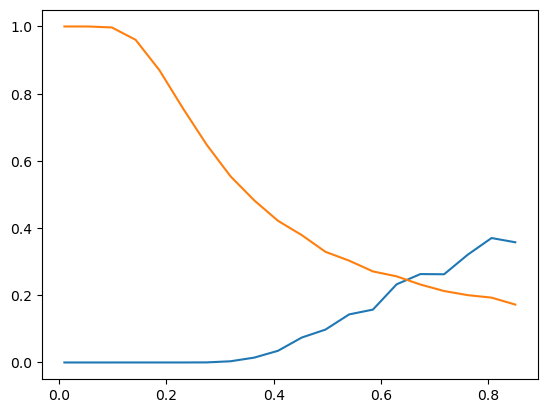

In [8]:
plt.plot(A_mean,fluc_mean_1d)
plt.plot(A_mean,div_mean_1d)

(array([ 0.,  0.,  6., 24., 79., 47., 49., 60., 31., 35., 12., 16., 10.,
        11.,  4.,  6.,  5.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
        0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
        0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ,
        0.42857143, 0.45714286, 0.48571429, 0.51428571, 0.54285714,
        0.57142857, 0.6       , 0.62857143, 0.65714286, 0.68571429,
        0.71428571, 0.74285714, 0.77142857, 0.8       , 0.82857143,
        0.85714286, 0.88571429, 0.91428571, 0.94285714, 0.97142857,
        1.        ]),
 <BarContainer object of 35 artists>)

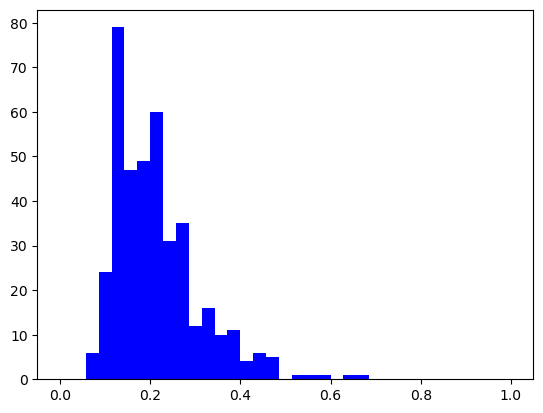

In [9]:
plt.hist(diversity_record_1d[16], bins=35, range=(0,1), alpha=1, color='b')

(array([253.,  12.,  16.,  12.,  12.,  10.,  11.,  10.,  13.,   6.,   9.,
         13.,   9.,   2.,   4.,   4.,   1.,   1.,   0.,   2.]),
 array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ,
        0.66, 0.72, 0.78, 0.84, 0.9 , 0.96, 1.02, 1.08, 1.14, 1.2 ]),
 <BarContainer object of 20 artists>)

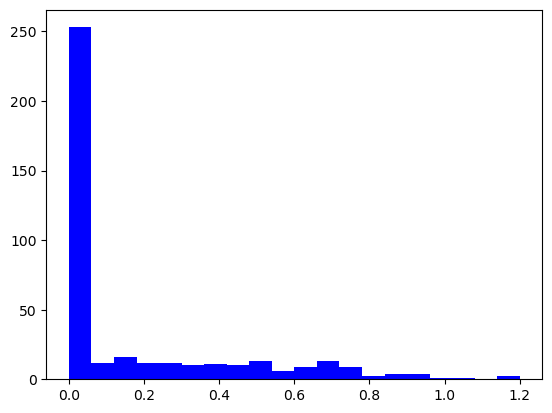

In [10]:
plt.hist(fluc_record_1d[16], bins=20, range=(0,1.2), alpha=1, color='b')

[6.81951243e-15 5.22136409e-15 5.34696663e-07 3.88356571e-06
 1.03999209e-05 2.89556216e-05 2.28918552e-04 2.99788229e-03
 1.16828519e-02 2.66924921e-02 5.43655014e-02 7.29133509e-02
 1.06767602e-01 1.12600299e-01 1.57203038e-01 1.72349150e-01
 1.66913583e-01 2.00552020e-01 2.37790430e-01 2.14206475e-01]


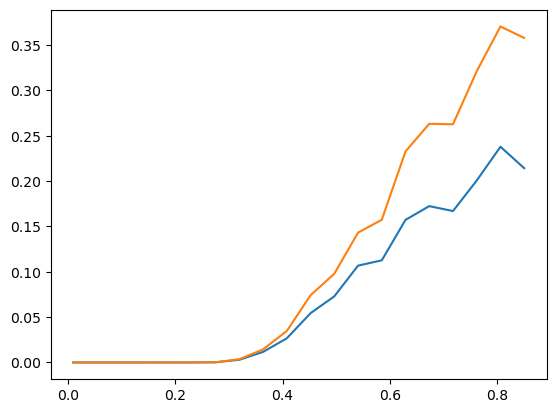

In [11]:
fluc_mean_1d_2 = np.zeros((ystep))
for pp in range(ystep):
    fluc_mean_1d_2[pp] = np.mean(fluc_record_1d[pp])
plt.plot(A_mean,fluc_mean_1d_2)
plt.plot(A_mean,fluc_mean_1d)
print(fluc_mean_1d_2)


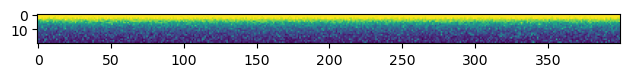

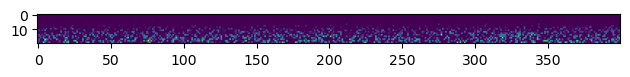

In [12]:
    
plt.imshow(diversity_record_1d)
plt.tight_layout()
plt.show()
plt.imshow(fluc_record_1d)
plt.tight_layout()
plt.show()

0.08 8.03812660792483e-15


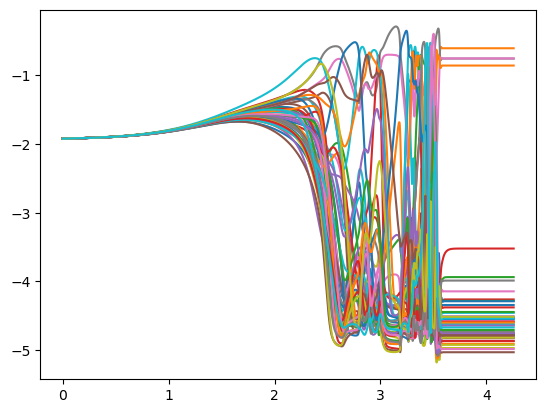

In [13]:
num_s = 50
x_zhou = np.arange(T)
composition = LV_compute(num_s, DD, 1.4, T, step)
for i in range(num_s):
    plt.plot(np.log(x_zhou+1)*0.43,np.log(composition.T[i])*0.43)

richness,fluc_CV = axis_of_cols(composition[T - 500:T], 50)
rich = richness/50
fluc = np.sum(fluc_CV)/richness
print(rich,fluc)